In [160]:
import pandas as pd
import numpy as np
import optuna
import gc
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_percentage_error,r2_score,mean_squared_error
from sklearn.model_selection import TimeSeriesSplit,cross_val_score
from datetime import date
from datetime import datetime
from imblearn.pipeline import Pipeline 
from sklearn.cluster import KMeans
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import os
pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', 50)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        
def label_data(feature,data,le_fit=None):
    if type(feature)==str:
        feature=[feature]
    else :
        pass
    for col in feature:
        le=LabelEncoder()
        le_fit.update({col:le.fit(data[col])})
        data[col]=le.transform(data[col])
    return data[feature],le_fit

def info_data(df):
    cm = sns.light_palette("red", as_cmap=True)
    null=(df.isnull().sum()/df.shape[0]).to_frame().rename(columns={0:'null_rate'})
    unique=df.nunique().to_frame().rename(columns={0:'nunique'})
    dtype=pd.Series({feature:df[feature].dtype.name  for feature in df.columns}).to_frame().rename(columns={0:'dtype'})
    return pd.merge(null, unique,left_index=True, right_index=True).merge(dtype,left_index=True, right_index=True).sort_values('null_rate',ascending=False).style.background_gradient(cmap=cm)
        
        
train=pd.read_csv('/kaggle/input/gdz-elektrik-datathon-2023/train.csv').rename(columns={'Dağıtılan Enerji (MWh)':'tüketim'})
test=pd.read_csv('/kaggle/input/gdz-elektrik-datathon-2023/sample_submission.csv').rename(columns={'Dağıtılan Enerji (MWh)':'tüketim'})
med=pd.read_csv('/kaggle/input/gdz-elektrik-datathon-2023/med.csv')
submission=pd.read_csv('/kaggle/input/gdz-elektrik-datathon-2023/sample_submission.csv')


/kaggle/input/gdz-elektrik-datathon-2023/sample_submission.csv
/kaggle/input/gdz-elektrik-datathon-2023/med.csv
/kaggle/input/gdz-elektrik-datathon-2023/train.csv


In [161]:
def create_features(df, label=None):
    df['datetime'] = pd.to_datetime(df.index)
    df['hour'] = df['datetime'].dt.hour
    df['date'] = df['datetime'].dt.date
    df['dayofweek'] = df['datetime'].dt.dayofweek
    df['quarter'] = df['datetime'].dt.quarter
    df['month'] = df['datetime'].dt.month
    df['year'] = df['datetime'].dt.year
    df['dayofyear'] = df['datetime'].dt.dayofyear
    df['dayofmonth'] = df['datetime'].dt.day
    df['weekofyear'] = df['datetime'].dt.weekofyear
    df['weekday']=df['datetime'].dt.weekday
    df['wntr_month']=df.apply(lambda x: 1 if x.month in ([11,12,1,2]) else 0,axis=1) 
    df['month_label']=df.month.map(lambda x : '1' if x in ([11,12,1,2,3]) else ( '2' if x in ([6,7,8,9]) else '3' ))
    df['quarter']=df.month.map(lambda x : '1_çeyrek' if x in ([1,2,3]) else ( '2_çeyrek' if x in ([4,5,6]) else( '3_çeyrek' if x in ([7,8,9]) else '4_çeyrek') ))
    df['season']=df.month.map(lambda x : 'kış' if x in ([12,1,2]) else ( 'ilkbahar' if x in ([3,4,5]) else( 'yaz' if x in ([6,7,8]) else 'sonbahar') ))
    df['weekend']=df.dayofmonth.map(lambda x:  'hafta_içi' if x<5 else 'hafta_sonu')
    df['working_hours']=df.hour.map(lambda x: 'work_hour' if (x<7) & (x>19) else 'not_work_hour' )
    df['label_hour']=df.hour.map(lambda x : '1' if x>22 & x<24 else ('2' if x>0 & x<6 else ('3' if x>5 & x<10 else ('4' if x>9 & x<13  else ('5' if x>12 & x<17 else('6' if x>16 & x<21 else '7'))) )))
    df['prime_time']=df.hour.map(lambda x: 'prime' if (x>19) & (x<22) else 'not_prime' )
    df=df.drop('datetime',axis=1)
#     X = df[['hour','dayofweek','quarter','month','year',
#            'dayofyear','dayofmonth','weekofyear']]
#     if label:
#         y = df[label]
#         return df, y
    return df

train = create_features(train.set_index('Tarih'))
test= create_features(test.set_index('Tarih'))
test['tüketim']=test['tüketim'].replace(0,np.nan)
train.index=pd.to_datetime(train.index)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # This is added back by InteractiveShellApp.init_path()


In [162]:
outlier_treshold_up=train.tüketim.std()*2.5+train.tüketim.mean()
outlier_treshold_down=train.tüketim.mean()-train.tüketim.std()*2.5
print(f'outlier_treshold_up: {outlier_treshold_up:.2f},\noutlier_treshold_down: {outlier_treshold_down:.2f}')
train[train.tüketim<outlier_treshold_down]
print('Datamızda  çok küçük değerlerden kaynaklanan bir outlier durumumuz yok')

outlier_treshold_up: 2901.97,
outlier_treshold_down: 771.64


,tüketim,hour,date,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,wntr_month,month_label,season,weekend,working_hours,label_hour,prime_time
Tarih,,,,,,,,,,,,,,,,,,


Datamızda  çok küçük değerlerden kaynaklanan bir outlier durumumuz yok


In [163]:
info_data(train)

,null_rate,nunique,dtype
tüketim,0.000000,40151,float64
hour,0.000000,24,int64
label_hour,0.000000,3,object
working_hours,0.000000,1,object
weekend,0.000000,2,object
season,0.000000,4,object
month_label,0.000000,3,object
wntr_month,0.000000,2,int64
weekday,0.000000,7,int64
weekofyear,0.000000,53,int64


In [164]:
# Mean ve median değerlerimiz yakın standtart sapmamız çok yüksek değil ortalama etrafında bir dağılım  olduğunu gösterir
print(f'mode:{train.tüketim.mode()[0]}')
# Mean median mode değerlerine bakacak olursak dağımımız pozitif skewed diyebiliriz 
train.describe().T

mode:1873.699


,count,mean,std,min,25%,50%,75%,max
tüketim,40152.0,1836.805287,426.066085,870.18328,1499.165048,1813.409221,2129.407998,3633.105297
hour,40152.0,11.500000,6.922273,0.00000,5.750000,11.500000,17.250000,23.000000
dayofweek,40152.0,3.000000,2.000025,0.00000,1.000000,3.000000,5.000000,6.000000
month,40152.0,6.205619,3.404381,1.00000,3.000000,6.000000,9.000000,12.000000
year,40152.0,2019.817095,1.335099,2018.00000,2019.000000,2020.000000,2021.000000,2022.000000
dayofyear,40152.0,173.415421,104.082367,1.00000,84.000000,168.000000,261.000000,366.000000
dayofmonth,40152.0,15.720861,8.796085,1.00000,8.000000,16.000000,23.000000,31.000000
weekofyear,40152.0,25.230126,14.898213,1.00000,12.000000,24.000000,38.000000,53.000000
weekday,40152.0,3.000000,2.000025,0.00000,1.000000,3.000000,5.000000,6.000000
wntr_month,40152.0,0.322773,0.467543,0.00000,0.000000,0.000000,1.000000,1.000000


In [165]:
train[train.duplicated()] #data da duplicated değer yok

,tüketim,hour,date,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,wntr_month,month_label,season,weekend,working_hours,label_hour,prime_time
Tarih,,,,,,,,,,,,,,,,,,


In [166]:
outlier_treshold_up=train.tüketim.std()*2.5+train.tüketim.mean()
outlier_treshold_down=train.tüketim.mean()-train.tüketim.std()*2.5
print(f'outlier_treshold_up: {outlier_treshold_up:.2f},\noutlier_treshold_down: {outlier_treshold_down:.2f}')

outlier_treshold_up: 2901.97,
outlier_treshold_down: 771.64


In [167]:
# Datamızda  çok küçük değerlerden kaynaklanan bir outlier durumumuz yok
train[train.tüketim<outlier_treshold_down]

,tüketim,hour,date,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,wntr_month,month_label,season,weekend,working_hours,label_hour,prime_time
Tarih,,,,,,,,,,,,,,,,,,


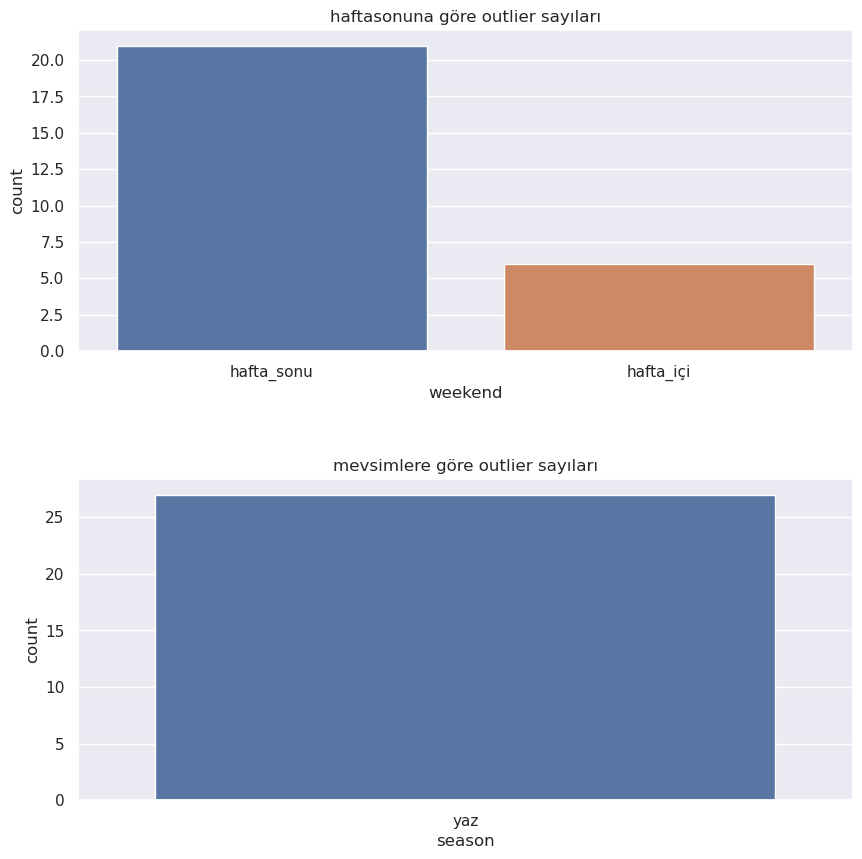

In [168]:
# Outlierlarımız yaz aylarında ve hafta sonlarında görülmekte buda mantıklı.
# Yıl içerisindeki primetime olarak değerlendirebilceğimiz dönemlerde outlierlarımız var.
sns.set(rc={'figure.figsize':(10,10)})
plt.subplot(2,1,1)
sns.countplot(x=dum[dum.outlier=='yes'].weekend).set_title('haftasonuna göre outlier sayıları');plt.subplot(2,1,2)
plt.subplots_adjust(hspace = 0.4)
sns.countplot(x=dum[dum.outlier=='yes'].season).set_title('mevsimlere göre outlier sayıları');

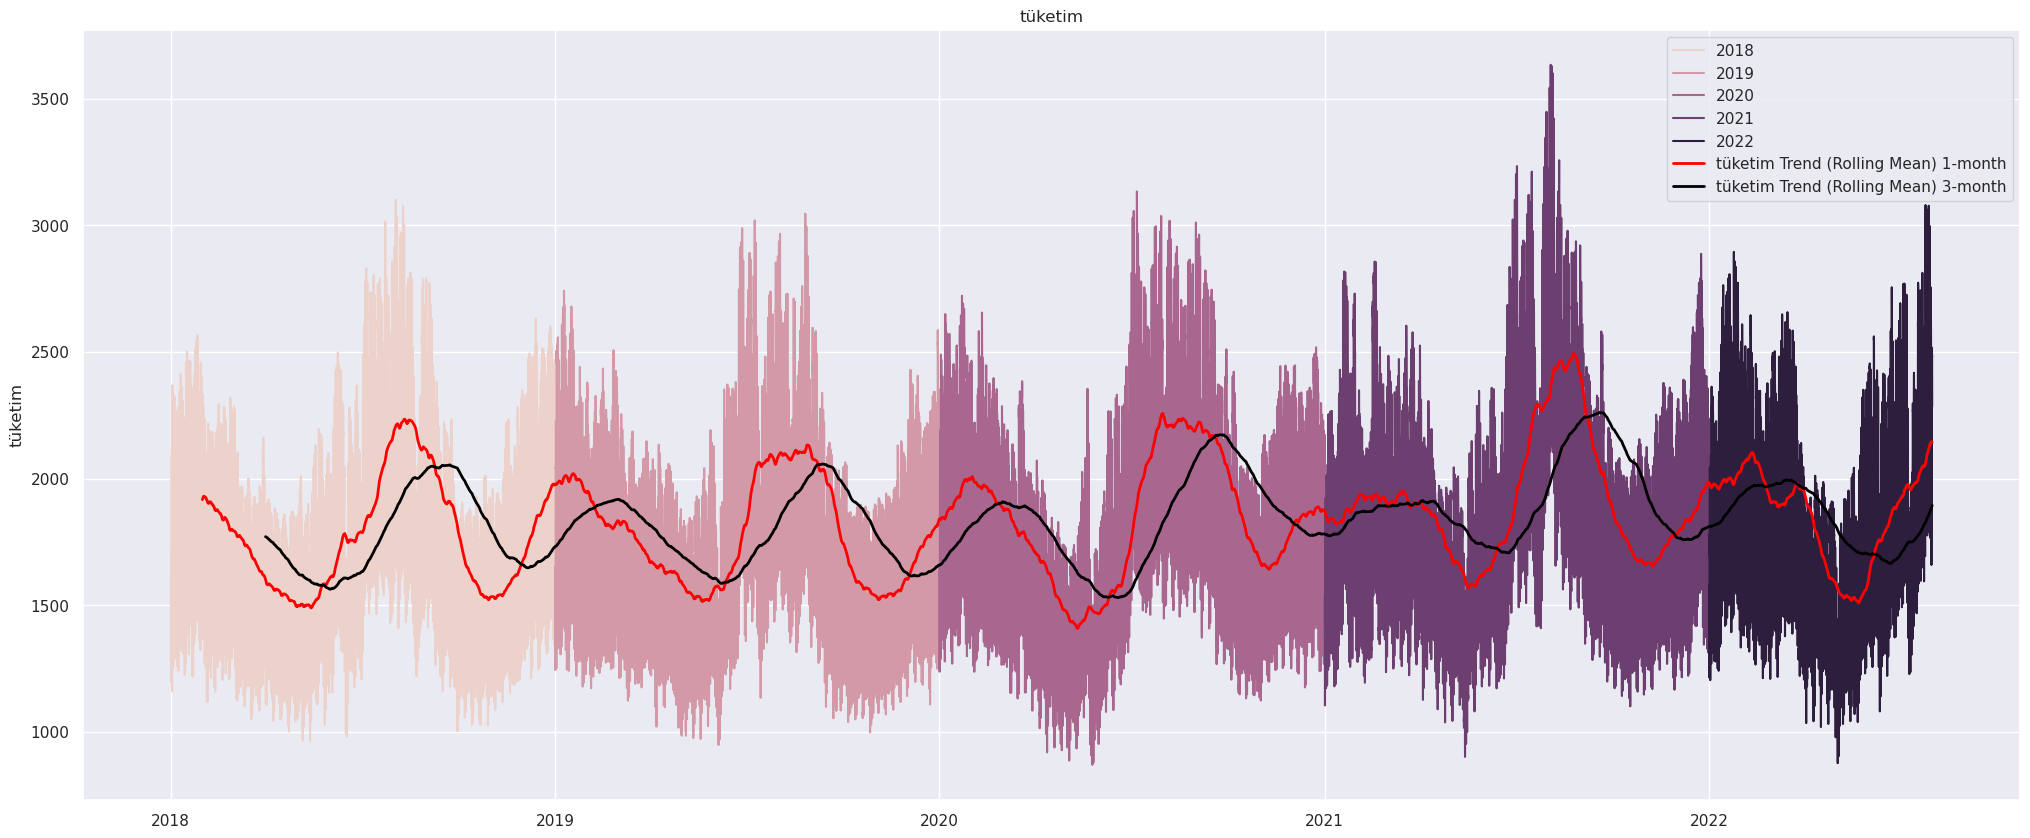

In [169]:
# Burada elektrik tüketiminde  sezonluk değişimlerin olduğu gözleniyor.
# Yine burada sezonsal bir durumun olduğunu gözlemleyebiliyoruz.
sns.set(rc={'figure.figsize':(25,10)})
sns.lineplot(x=train.index.values, y="tüketim", hue=train.year,data=train).set_title('tüketim')
plt.plot(train.tüketim.rolling(24*30).mean(), alpha=1, color='red', label='tüketim Trend (Rolling Mean) 1-month', linewidth = 2.0)
plt.plot(train.tüketim.rolling(24*30*3).mean(), alpha=1, color='black', label='tüketim Trend (Rolling Mean) 3-month', linewidth = 2.0)
plt.legend();

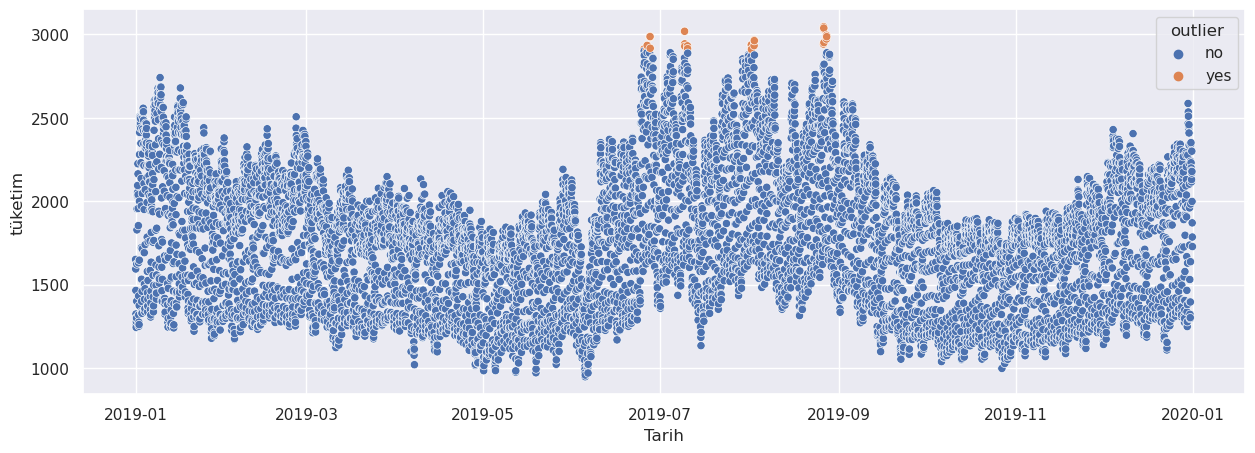

In [170]:
# Tek bir yıl için çizdirdim daha detayli görülebilmesi için.
# Outlierlarımız  genelde yaz aylarında gözlemleniyor.
sns.set(rc={'figure.figsize':(15,5)})
dum=train[train.year==2019].copy()
dum['outlier'] = np.where(dum['tüketim']>outlier_treshold_up, 'yes', 'no')
sns.scatterplot(x=dum.index,y='tüketim',data=dum,hue=dum.outlier);


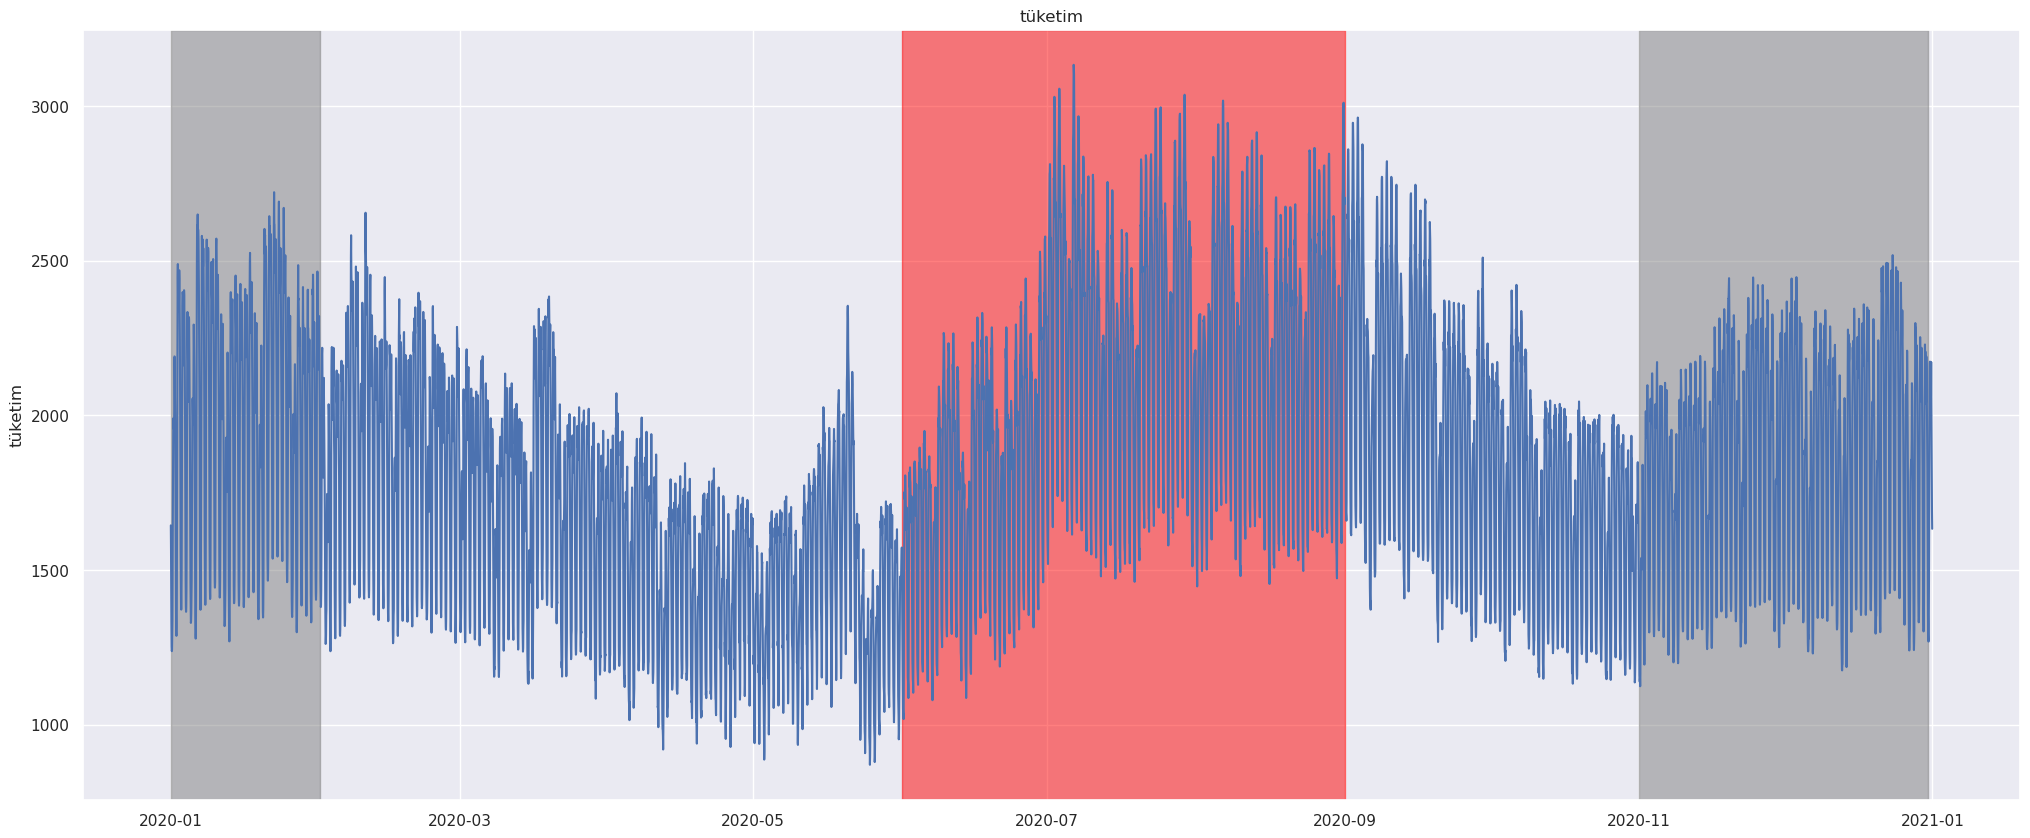

In [171]:
# Sadece bir  yıl için bakacak olursak yaz aylarında enerji tüketiminin en yüksek.
# Kış ayalarında da enerji tüketimi yüksek fakat ilkbahar ve sonbahar aylarında yaza ve kışa göre nispeten elektrik tüketimi daha az
sns.set(rc={'figure.figsize':(25,10)})
sns.lineplot(x=train[train.year==2020].index.values, y="tüketim",data=train[train.year==2020]).set_title('tüketim');
plt.axvspan('2020-06-01 00:00:00','2020-09-01 00:00:00',color="red",alpha=0.5)
plt.axvspan('2020-01-01 00:00:00','2020-02-01 00:00:00',color="grey",alpha=0.5) 
plt.axvspan('2020-11-01 00:00:00','2020-12-31 00:00:00',color="grey",alpha=0.5) ;

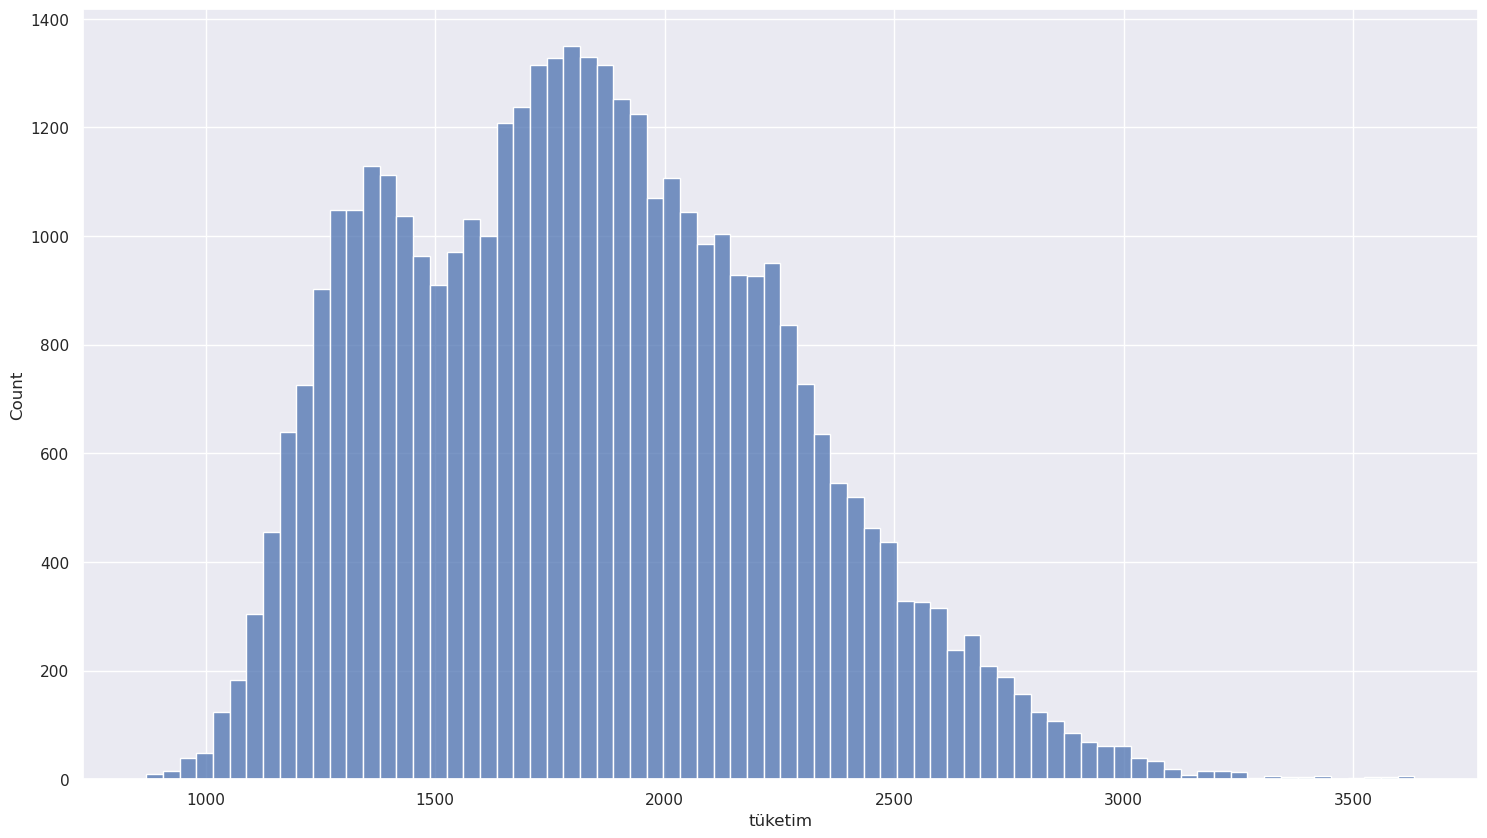

In [172]:
# Verimizin dağılımı normal değil.Dağılımın right skewed olduğunu söyleyebiliriz.
sns.set(rc={'figure.figsize':(18,10)})
sns.histplot(x=train.tüketim);

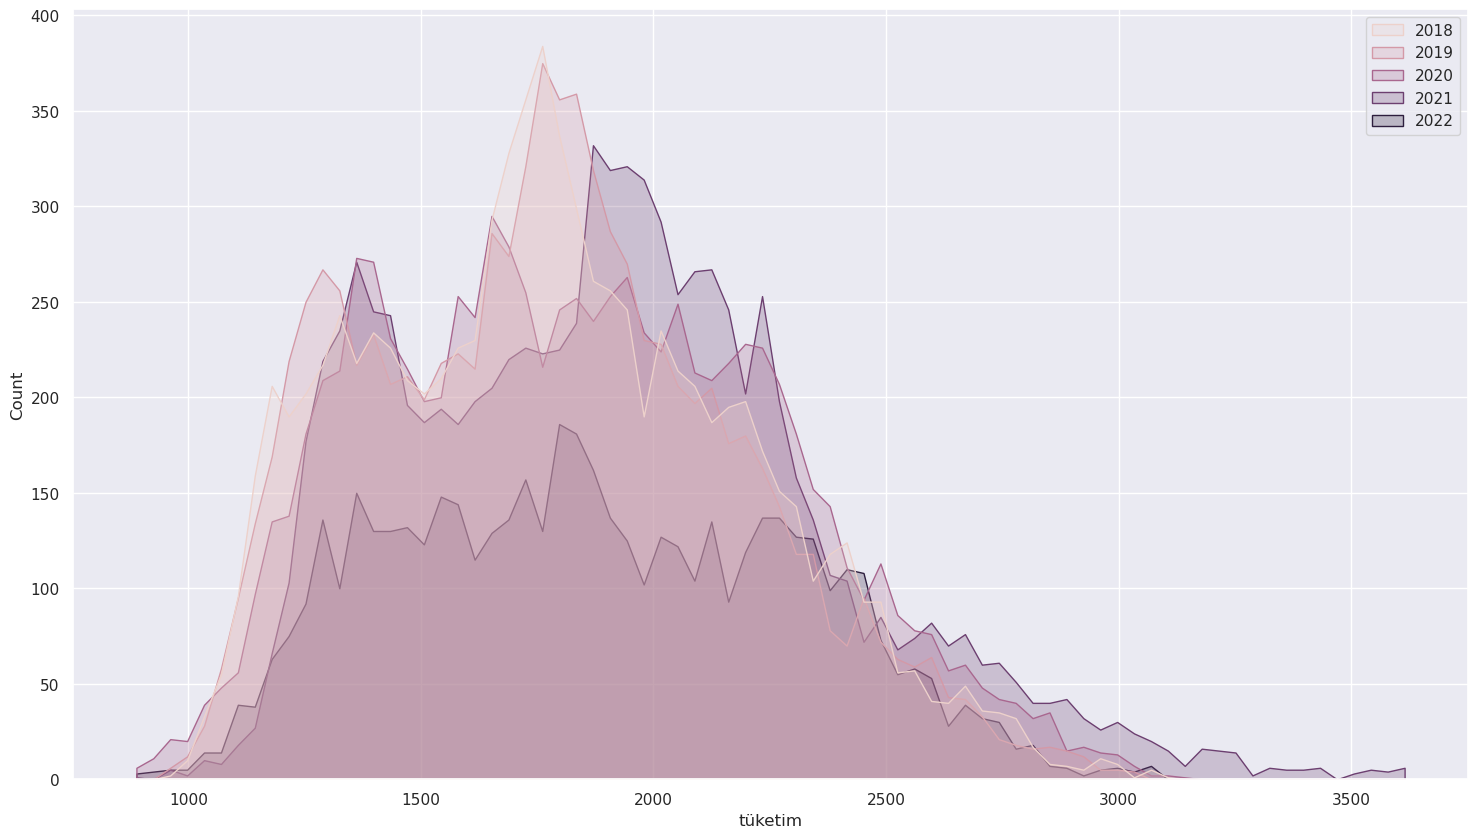

In [173]:
# Yıllara göre baktığımız da dağılımların birbine yakın olduğunu  gözlemleyebiliyoruz.
sns.histplot(x=train.tüketim ,hue=train.year.values, element="poly");

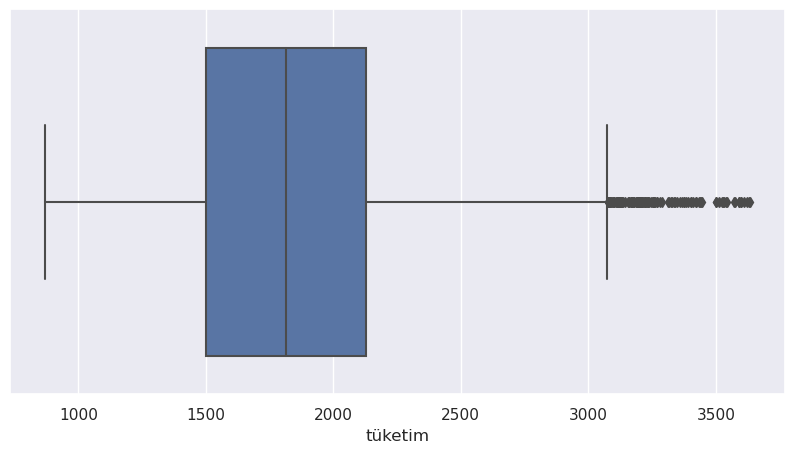

In [174]:
# Outlier değerler
sns.set(rc={'figure.figsize':(10,5)})
sns.boxplot(x=train.tüketim);

<Figure size 2000x1000 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Yıllara göre ortalama tüketim')

<AxesSubplot:>

Text(0.5, 1.0, 'Yıllara göre Toplam tüketim')

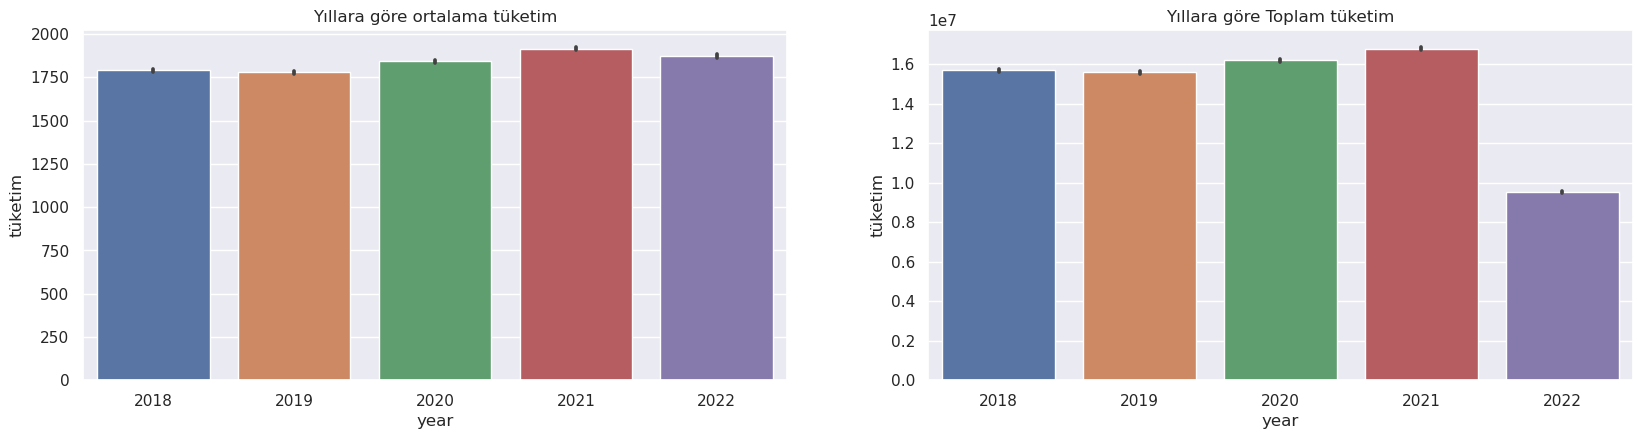

In [175]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
# Yıllara göre ortalama tüketimde  bir artış var.
ax=sns.barplot(x='year',y='tüketim',data=train.reset_index());
ax.set_title('Yıllara göre ortalama tüketim')
plt.subplot(2,2,2)
# Yıllara göre toplam tüketimde bir artış var.
ax=sns.barplot(x='year',y='tüketim',data=train.reset_index(),estimator='sum');
ax.set_title('Yıllara göre Toplam tüketim')

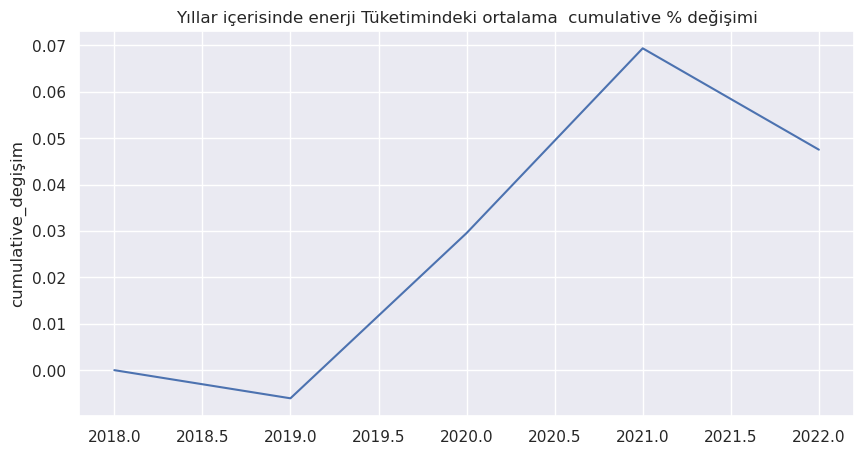

In [176]:
# Burada ortalama enerji tüketiminin yıllar içerisinde arttığını gözlemliyoruz ama artış hızında bir azalma var.
dum=train.groupby(['year'])['tüketim'].mean().reset_index()
dum['cumulative_degişim']=dum.tüketim.pct_change().cumsum().fillna(0)
ax=sns.set(rc={'figure.figsize':(10,5)})
ax=sns.lineplot(x=dum.year.values,y=dum.cumulative_degişim).set_title('Yıllar içerisinde enerji Tüketimindeki ortalama  cumulative % değişimi')

Text(0.5, 1.0, 'Yıllara göre mevsimsel olarak ortalama tüketim')

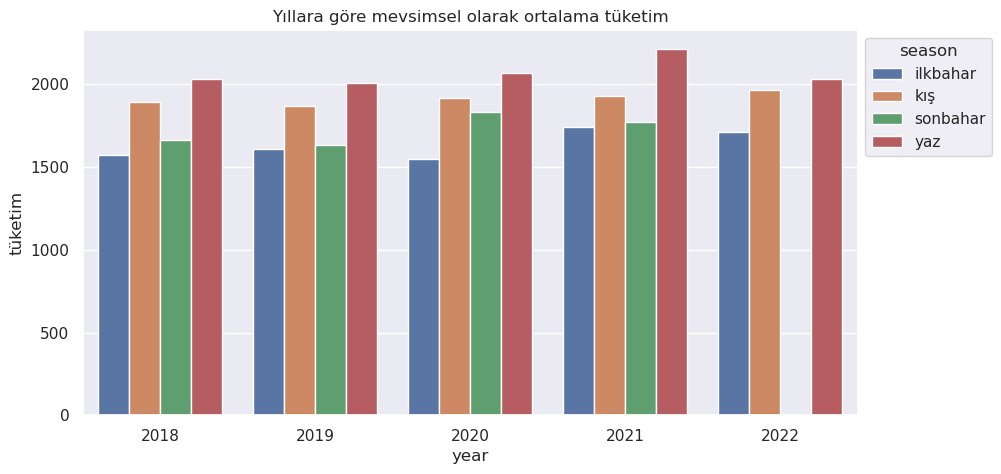

In [177]:
# Mevsimlik bazda ortalama tüketimler.
# Kış aylarında ısınma için kullanılan elektrik miktarının artması tüketimi artırabilir.
# Yaz aylarında soğutma için kullanılan elektrik miktarı elektrik tüketimini artırabilir.
dum=train.groupby(['year','season'])['tüketim'].mean().reset_index()
sns.set(rc={'figure.figsize':(10,5)})
ax=sns.barplot(x='year',y='tüketim',hue='season',data=dum)
ax.set_title('Yıllara göre mevsimsel olarak ortalama tüketim')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

Text(0.5, 1.0, 'Yıllara göre aylık ortalama tüketim')

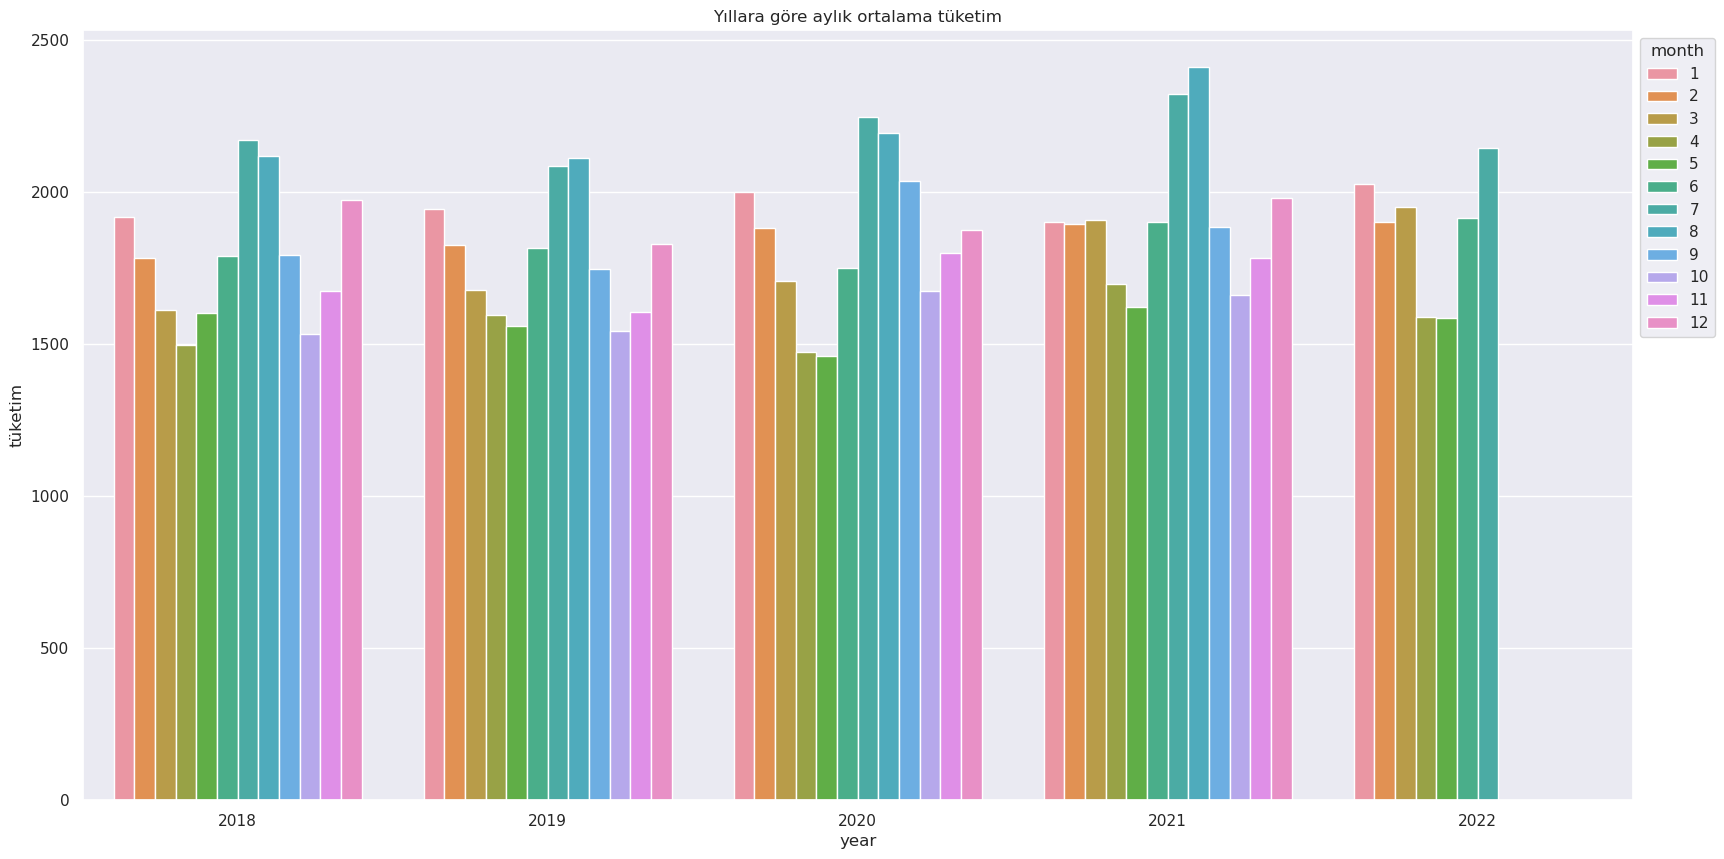

In [178]:
# Yıllara göre aylık ortalma tüketim miktarları
# Yine burada genel trendin yıllar içerisinde aynı olduğunu gözlemleyebiliriz.
# İlkbahar ve sonbahar aylarında yaz ve kış aylarına göre tüketim daha düşük kalmakta.
dum=train.groupby(['year','month'])[['tüketim']].mean().reset_index()
sns.set(rc={'figure.figsize':(20,10)})
ax=sns.barplot(x='year',y='tüketim',hue='month',data=dum)
ax.set_title('Yıllara göre aylık ortalama tüketim')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

Text(0.5, 1.0, 'Yıllara göre günlük  tüketim')

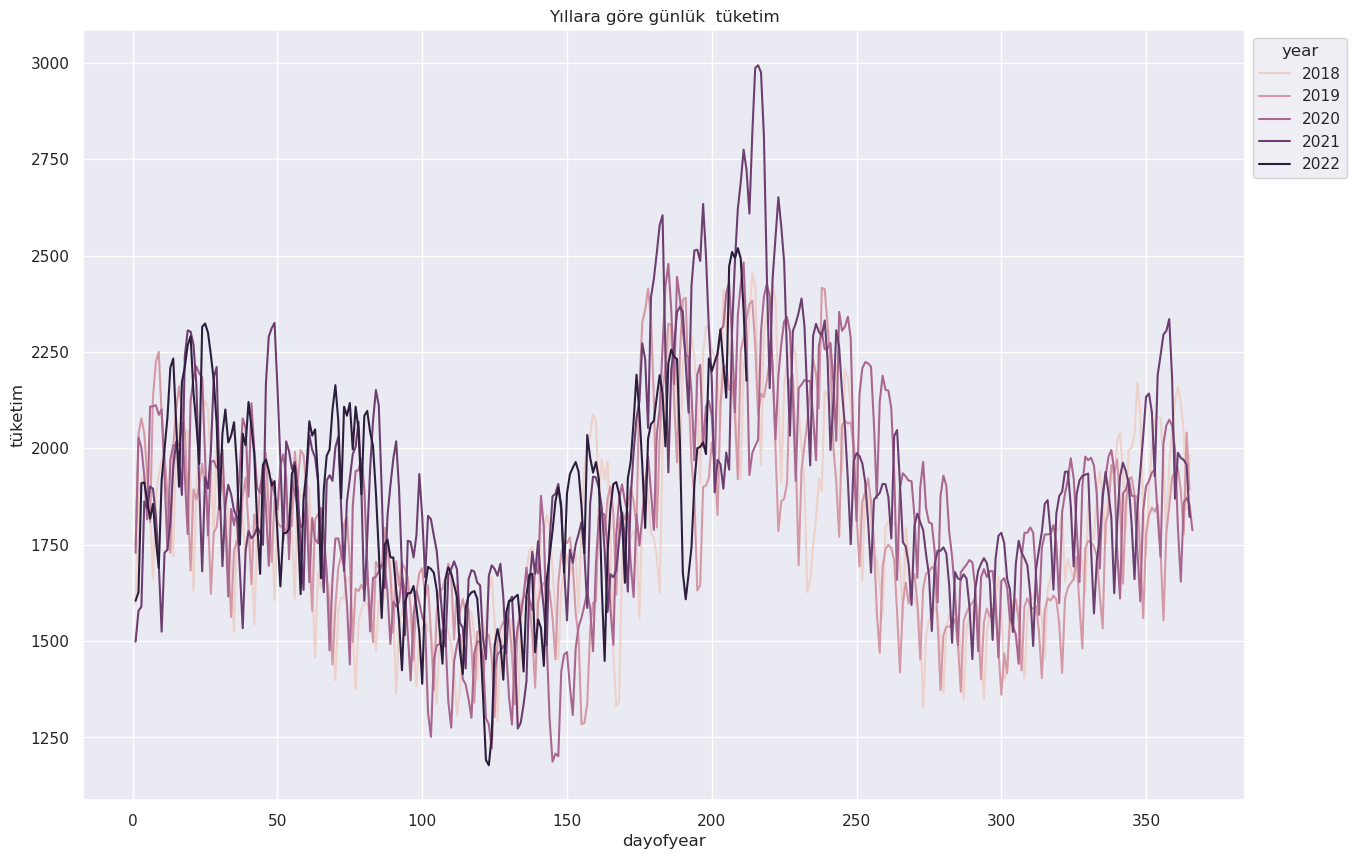

In [179]:
# Yine burada da yıllara göre günlük tüketim miktarlarını çizdirdim yaz ve kış günlerinde tüketim fazla
dum=train.groupby(['year','dayofyear'])[['tüketim']].mean().reset_index()
sns.set(rc={'figure.figsize':(15,10)})
ax=sns.lineplot(x=dum.dayofyear,y=dum.tüketim,hue=dum.year,legend=all)
ax.set_title('Yıllara göre günlük  tüketim')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

Text(0.5, 1.0, 'Yıllara göre aylık ortalama tüketim')

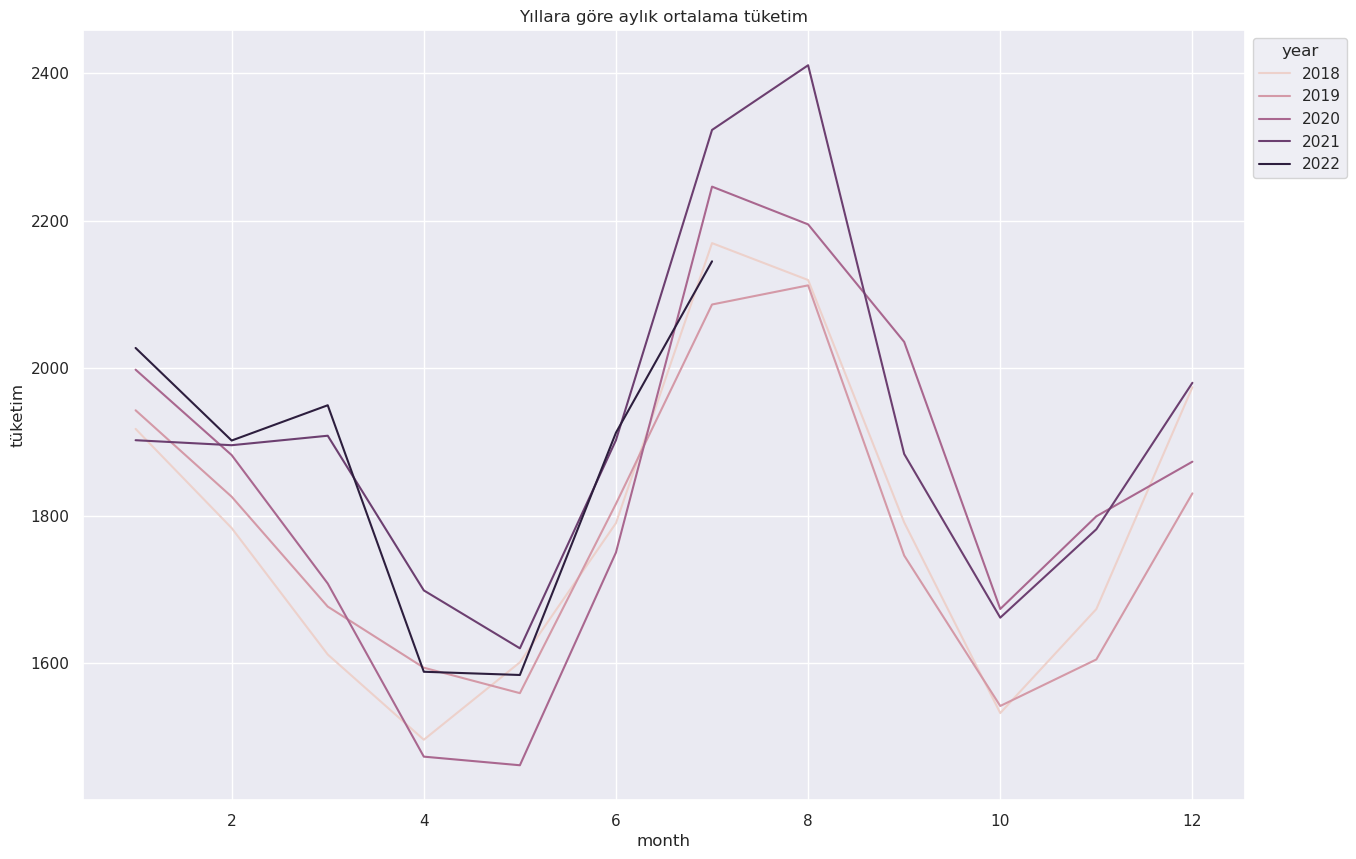

In [180]:
# Aylara göre batığımızda bir seasonality gözlemliyoruz ilkbahar ve sonhar aylarında enerji tüketimi yaz ve kış aylarına göre nispeten daha az 
# Bunu kışın ısınmadan kaynaklı yazın ise soğutmadan kaynaklı enerji tüketimi ile açıklayabiliriz.
dum=train.groupby(['year','month'])[['tüketim']].mean().reset_index()
sns.set(rc={'figure.figsize':(15,10)})
ax=sns.lineplot(x=dum.month,y=dum.tüketim,hue=dum.year,legend=all,linewidth = 1.5)
ax.set_title('Yıllara göre aylık ortalama tüketim')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

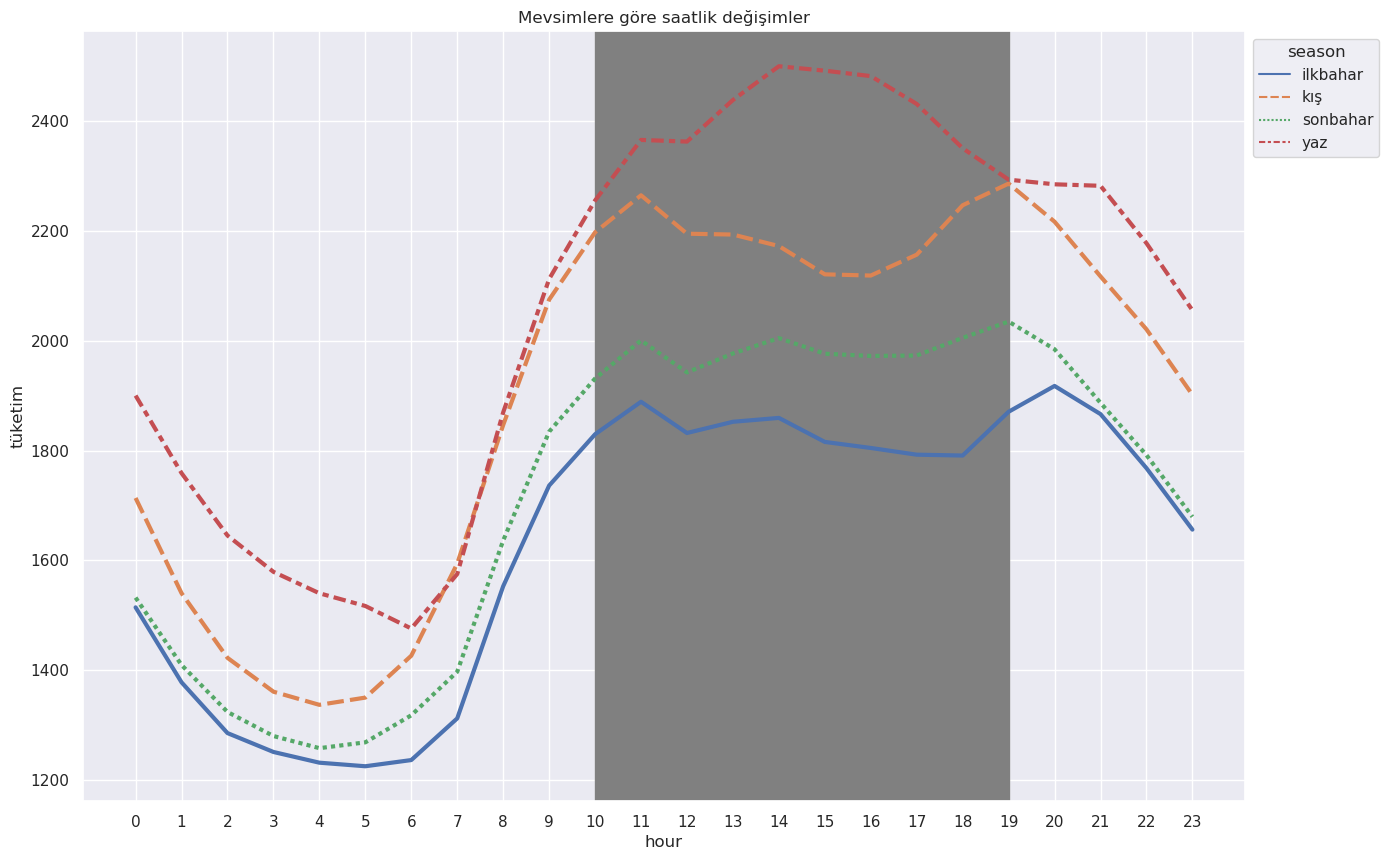

In [181]:
# Gri ile boyalı alan kışın  insanların işte olduğu vakitlerde elektrik tüketimi azalmakta fakat 
# Prime time(19.00 - 22.00)  zaman diliminde insalar işten dönüş evdeki elektrikli araçların çalışması(çamaşır mak.,bulaşık mak., gibi) elektrik tüketimi artıyor.
# Aynı şeyleri yaz ayları içinde söyleyebiliriz fakat burda şöyle bir durum var kışın ısınmak için illa elektriğe  ihtiyaç duyulmayabilir(hidrokarbon yakıtlar ile ısınma sağlanabilir)
# ama yaz aylarında soğutma için elektrik şart bu yüzden yaz döneminde gerek evlerde gerek iş yerlerinde soğutma için elektrik tüketilir buda yaz aylarında elektirk tüketim talebinin yüksek olmasını açıklar. 
# Gece saatlerinde elektrik tüketimi gün içine göre daha az gece activetenin azaldığını dünüşürsek bu mantıklı.

dum=train.groupby(['season','hour'])[['tüketim']].mean().reset_index()
sns.set(rc={'figure.figsize':(15,10)})
ax=sns.lineplot(x=dum.hour,y=dum.tüketim,hue=dum.season,legend=all,linewidth=3,style=dum.season)
ax.set_title('Mevsimlere göre saatlik değişimler')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xticks(range(0,24));
plt.axvspan(10,19,color="gray") ;

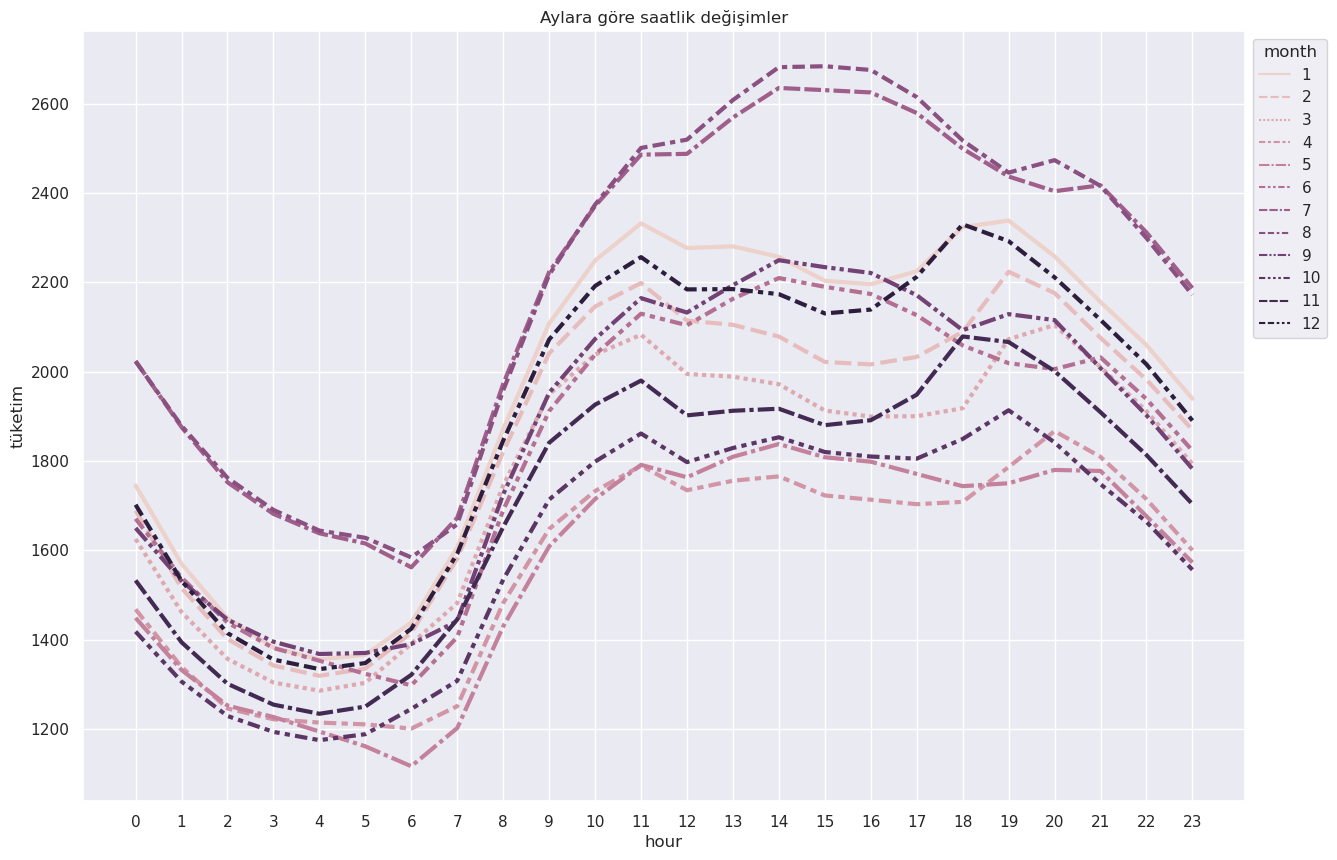

In [182]:
dum=train.groupby(['month','hour'])[['tüketim']].mean().reset_index()
sns.set(rc={'figure.figsize':(15,10)})
ax=sns.lineplot(x=dum.hour,y=dum.tüketim,hue=dum.month,legend=all,linewidth=3,style=dum.month)
ax.set_title('Aylara göre saatlik değişimler')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xticks(range(0,24));

Text(0.5, 1.0, 'Mevsimlere göre  haftaiçi/haftasonu  ortalama tüketim')

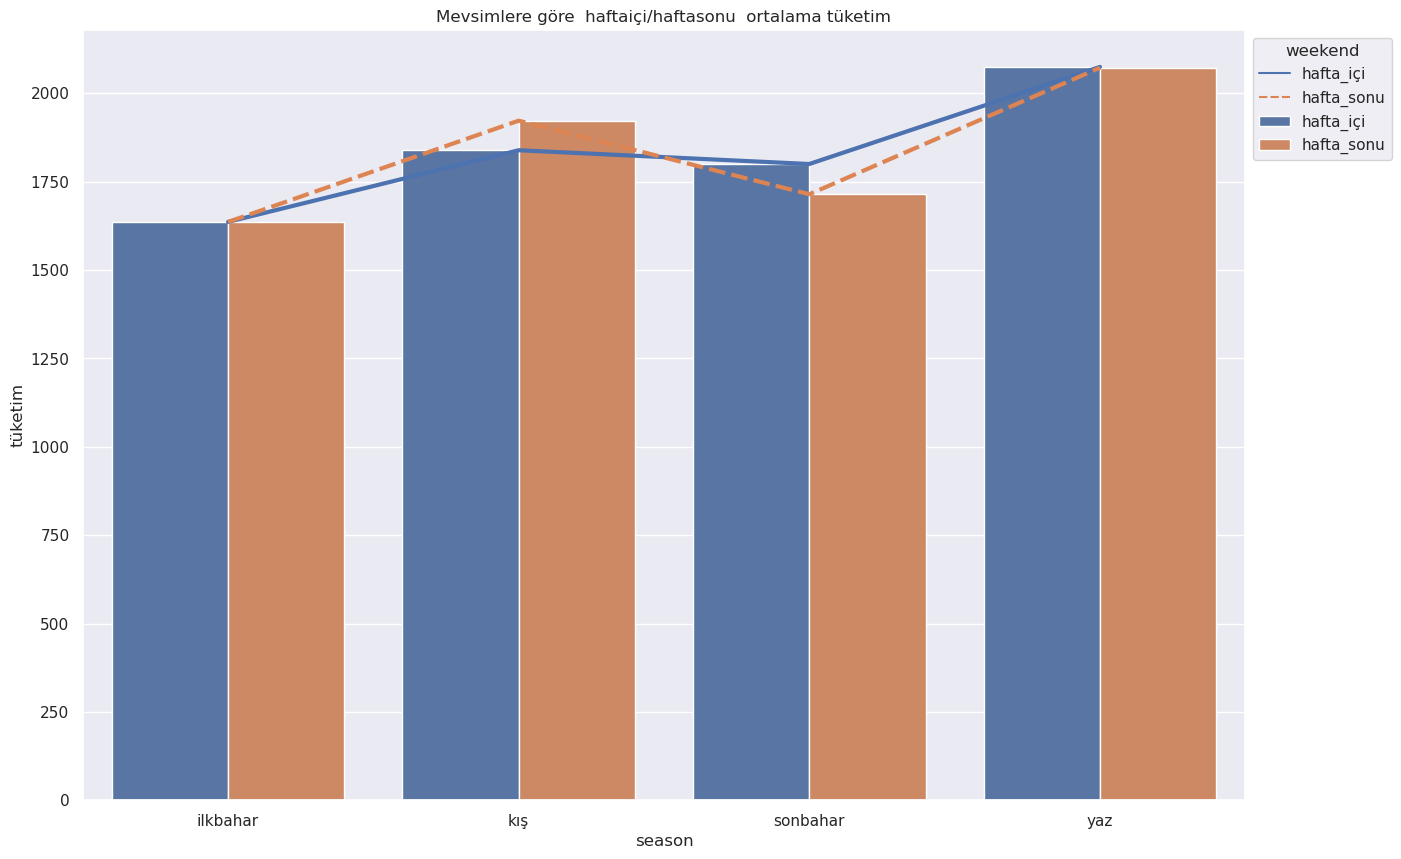

In [183]:
# Yaz ve Kış aylarında haftasonları elektrik tüketimi ortalaması daha yüksek.
# Yaz ayı için hafta içi insanların işte hafta sonları da evde olduğunu düşünürsek,iş te olmaları ev ısıtması için enerji tüketim talebini artırır hafta sonu evde soğutma için tüketim talebi daha fazla olabilir.
# Kış ayında ısınma talebi hafta sonu insanlar evde olduklarında daha fazla olabilri buda tüketimi artırabilir.
# Sonbahar ve İlkbahar ayları nispeten elektrik tüketimi daha az.
dum=train.groupby(['season','weekend'])[['tüketim']].mean().reset_index()
sns.set(rc={'figure.figsize':(15,10)})
ax=sns.lineplot(x=dum.season,y=dum.tüketim,hue=dum.weekend,legend=all,linewidth=3,style=dum.weekend)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax=sns.barplot(x=dum.season,y=dum.tüketim,hue=dum.weekend)
ax.set_title('Mevsimlere göre  haftaiçi/haftasonu  ortalama tüketim')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

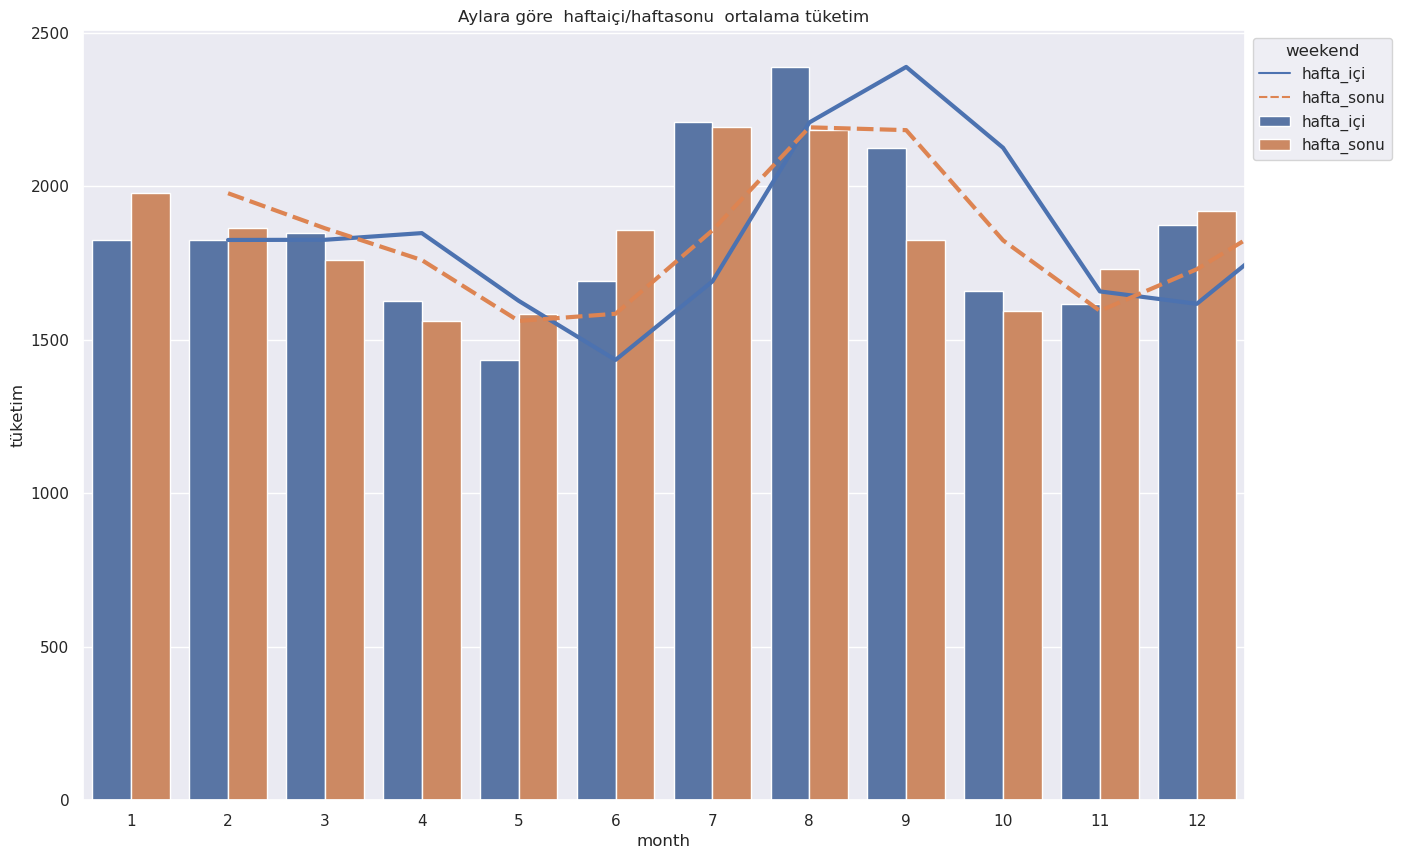

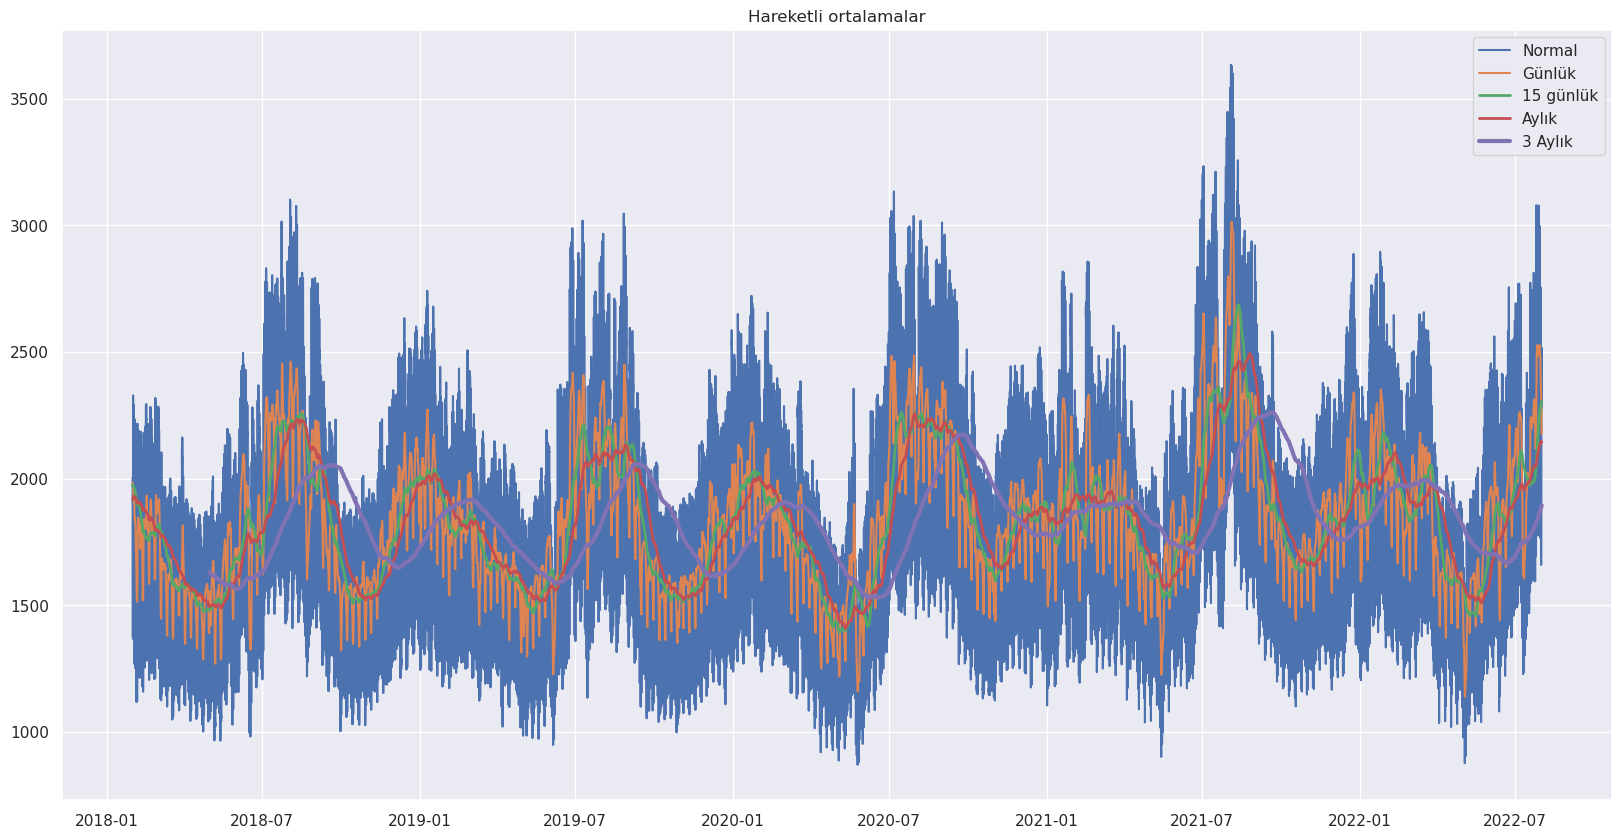

In [184]:
# İlkbahar ve sonbahar aylarına girerken hafta sonları enerji tüketimi hafta içine göre daha düşük
# İlkbahhar ve sonbahar aylarından cıkarken(yani yaz ve kış aylarına girmeye başladığımızda) bu durum tam tersine dönüyor.

dum=train.groupby(['month','weekend'])[['tüketim']].mean().reset_index()
sns.set(rc={'figure.figsize':(15,10)})
ax=sns.lineplot(x=dum.month,y=dum.tüketim,hue=dum.weekend,legend=all,linewidth=3,style=dum.weekend)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax=sns.barplot(x=dum.month,y=dum.tüketim,hue=dum.weekend)
ax.set_title('Aylara göre  haftaiçi/haftasonu  ortalama tüketim')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Günlük,15 günlük ve Aylık hareketli ortalamalarını feature olarak ekledim.
train["tüketim_roll"] = train["tüketim"].rolling(24).mean()  # Günlük 
train["tüketim_roll_2"] = train["tüketim"].rolling(24*15).mean() # 15 günlük
train["tüketim_roll_3"] = train["tüketim"].rolling(24*30).mean() # Aylık
train=train.dropna()
plt.figure(figsize=(20,10))
plt.title('Hareketli ortalamalar')
plt.plot(train.tüketim,label='Normal')
plt.plot(train.tüketim_roll,label='Günlük')
plt.plot(train.tüketim_roll_2,label='15 günlük',linewidth=2)
plt.plot(train.tüketim_roll_3,label='Aylık',linewidth=2)
plt.plot(train["tüketim"].rolling(24*30*3).mean(),label='3 Aylık',linewidth=3)
plt.legend();